<a href="https://colab.research.google.com/github/guebin/MP2024/blob/main/posts/05wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상 

{{<video https://youtu.be/playlist?list=PLQqh36zP38-yH7aA3RY7GNf1qNIgU6CDs&si=e4-tQHb8cD0FhrUW >}}

# 2. ref 

ref: <https://huggingface.co/docs/transformers/tasks/image_classification>

# 3. imports 

In [2]:
import datasets
import transformers
import torchvision.transforms
import evaluate
import numpy as np

/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 4. 코드정리1

In [3]:
## Step1 
### A. 데이터불러오기
food = datasets.load_dataset("food101", split="train[:5000]")
food = food.train_test_split(test_size=0.2)
### B. 전처리하기
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size), 
    torchvision.transforms.ToTensor(), 
    normalize
])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food = food.with_transform(transforms)
## Step2 
### A. 인공지능을 만들기 위한 준비코드 
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
### B. 인공지능 모델만들기     
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)
## Step3 
### A. 트레이너생성을 위한 준비 
data_collator = transformers.DefaultDataCollator()
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)
training_args = transformers.TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)
### B. 트레이너 생성
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)
### C. 트레이너를 이용한 학습
trainer.train()
## Step4 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
0,2.789800,2.609763,0.813000
2,1.631300,1.665686,0.883000


TrainOutput(global_step=186, training_loss=2.4969451658187376, metrics={'train_runtime': 142.3212, 'train_samples_per_second': 84.316, 'train_steps_per_second': 1.307, 'total_flos': 9.232831524962304e+17, 'train_loss': 2.4969451658187376, 'epoch': 2.976})

In [4]:
# Step4 
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-186")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [9]:
ds = datasets.load_dataset("food101", split="validation[:10]")
image = ds["image"][0]
classifier(image)

[{'label': 'beignets', 'score': 0.9650973677635193},
 {'label': 'hamburger', 'score': 0.6821807622909546},
 {'label': 'chicken_wings', 'score': 0.6256137490272522},
 {'label': 'bruschetta', 'score': 0.6200171709060669},
 {'label': 'prime_rib', 'score': 0.6096430420875549}]

# 5. 살펴보기 

## A. 데이터불러오기 

`-` 원래는 자료가 많음 

In [16]:
food_full = datasets.load_dataset("food101")
food_full
# 자료가 약 10만개, 자료형은 DatasetDict 임 

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

`-` train에서 5000장만 가져옴 

In [17]:
food5000 = datasets.load_dataset("food101", split="train[:5000]")
food5000
# 자료는 5000개, 자료형은 Dataset 


Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

`-` `food5000`에서 8:2로 데이터를 분리 

In [23]:
food = food5000.train_test_split(test_size=0.2)
food

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

## B. 데이터 살펴보기 

`-` 이미지를 보는 방법 

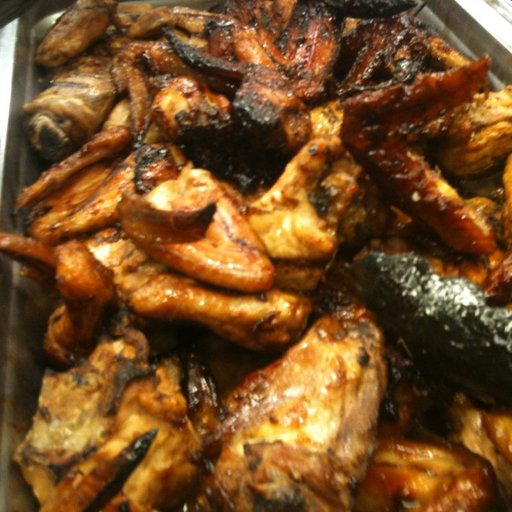

In [59]:
img = food['train'][0]['image']
img

In [61]:
type(img) # img의 자료형

PIL.JpegImagePlugin.JpegImageFile

`-` 이미지에 해당하는 라벨을 같이 확인하는 방법 

In [63]:
# food['train'][0]['image'] --- # 0번이미지
food['train'][0]['label'] # 0번이미지에 해당하는 라벨

20

20이 의미하는바가 무엇이지? 

In [65]:
labels = food['train'].features['label'].names # 라벨들의 정보들
labels[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [67]:
labels[20] # 20이라는 숫자가 의미하는 음식이름은 'chicken_wings' 임

'chicken_wings'

정리하면 

prime_rib


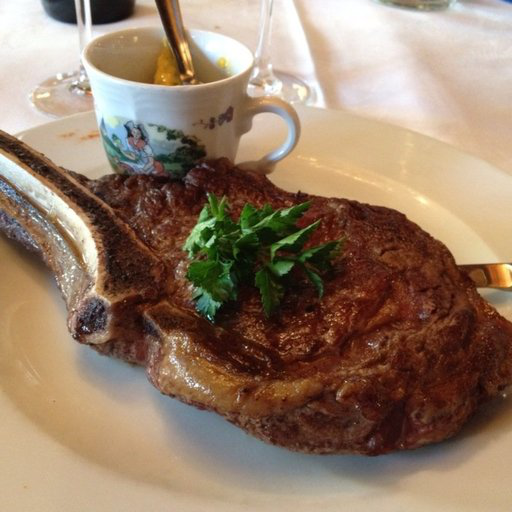

In [128]:
img_num = 11
print(labels[food['train'][img_num]['label']])
food['train'][img_num]['image']


`-` 이미지를 확인하면서 느낀점: 크기가 다름 $\to$ 각 이미지의 크기를 조사하고 싶다면? 

In [117]:
# 방법1 
food['train'][3]['image'].__str__().split(' ')[-3].split("=")[-1].split("x")
sizes = [l['image'].__str__().split(' ')[-3].split("=")[-1].split("x") for l in food['train']]
sizes[:4]

[['512', '512'], ['512', '384'], ['512', '512'], ['512', '512']]

In [124]:
# 방법2
sizes = [l['image'].size for l in food['train']]
sizes[:4]

[(512, 512), (512, 384), (512, 512), (512, 512)]

- 이미지의 크기가 서로 다르네? (텍스트의 길이가 서로 다르듯이?)
- 인공지능입장에서는 이렇게 이미지의 크기가 통일되어 있지 않다면 싫어하겠는걸? 
- 이미지를 resize 하여 크기를 통일시켜주는 코드가 어딘가 반드시 필요하겠군.. 

## C. `torchvision.transforms`

`-` 이미지자료 하나 받아두기 

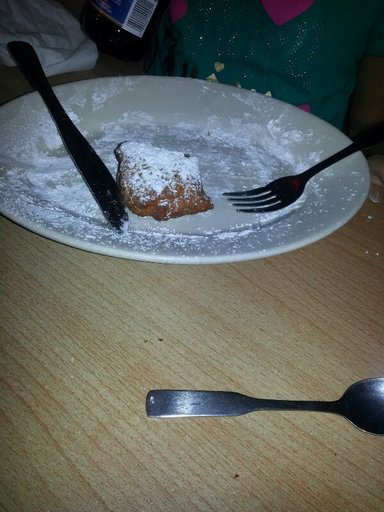

In [139]:
img = datasets.load_dataset("food101",split="train[:1]")[0]['image']
img

#### `# torchvision.transforms.RandomResizedCrop`

`# 예시1` -- 사이즈를 224,112로 조정 

In [159]:
자르고크기조정하기 = torchvision.transforms.RandomResizedCrop((224,112))

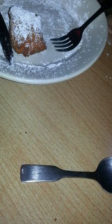

In [168]:
자르고크기조정하기(img)

`#` 

`# 예시2` -- 사이즈를 224,224로 조정 

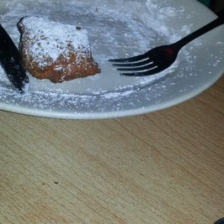

In [177]:
# 방법1
자르고크기조정하기 = torchvision.transforms.RandomResizedCrop((224,224))
자르고크기조정하기(img)

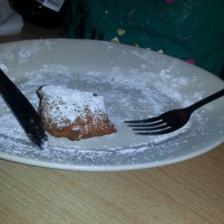

In [184]:
# 방법2
자르고크기조정하기 = torchvision.transforms.RandomResizedCrop(224)
자르고크기조정하기(img)

`#` 

#### `# torchvision.transforms.ToTensor()` 

`# 예시1` 

In [186]:
텐서화하기 = torchvision.transforms.ToTensor()

In [189]:
텐서화하기(img)

tensor([[[0.1216, 0.1137, 0.1098,  ..., 0.0039, 0.0039, 0.0000],
         [0.1255, 0.1216, 0.1176,  ..., 0.0039, 0.0039, 0.0000],
         [0.1294, 0.1255, 0.1255,  ..., 0.0039, 0.0000, 0.0000],
         ...,
         [0.2588, 0.2745, 0.2863,  ..., 0.3765, 0.3882, 0.3922],
         [0.2353, 0.2471, 0.2667,  ..., 0.3373, 0.3373, 0.3373],
         [0.2235, 0.2275, 0.2471,  ..., 0.3333, 0.3176, 0.3059]],

        [[0.1373, 0.1294, 0.1255,  ..., 0.1020, 0.1020, 0.0980],
         [0.1412, 0.1373, 0.1333,  ..., 0.1020, 0.1020, 0.0980],
         [0.1451, 0.1412, 0.1412,  ..., 0.1020, 0.0980, 0.0980],
         ...,
         [0.2471, 0.2627, 0.2745,  ..., 0.3647, 0.3765, 0.3882],
         [0.2235, 0.2353, 0.2549,  ..., 0.3255, 0.3333, 0.3333],
         [0.2118, 0.2157, 0.2353,  ..., 0.3216, 0.3137, 0.3020]],

        [[0.1412, 0.1333, 0.1294,  ..., 0.0902, 0.0902, 0.0863],
         [0.1451, 0.1412, 0.1451,  ..., 0.0902, 0.0902, 0.0863],
         [0.1490, 0.1451, 0.1529,  ..., 0.0902, 0.0863, 0.

In [190]:
텐서화하기(img).shape

torch.Size([3, 512, 384])

`#`

`# 예시2` -- `자르고크기조정하기` 와 `텐서화하기`를 동시에 사용하는 경우 

In [193]:
텐서화하기(자르고크기조정하기(img)).shape

torch.Size([3, 224, 224])

In [197]:
자르고크기조정하기(텐서화하기(img)).shape

torch.Size([3, 224, 224])

`#`

#### `# torchvision.transforms.Normalize`

`# 예시1`

In [227]:
표준화하기 = torchvision.transforms.Normalize(mean=[10,20,30],std=[0.5,1.0,1.5])

- `표준화하기`는 각 채널별로, `mean`을 뺸 뒤 `std`를 나눈 계산값을 리턴한다.

In [203]:
표준화하기(텐서화하기(img)) # 숫자들이 계산됨

tensor([[[-19.7569, -19.7725, -19.7804,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7490, -19.7569, -19.7647,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7412, -19.7490, -19.7490,  ..., -19.9922, -20.0000, -20.0000],
         ...,
         [-19.4824, -19.4510, -19.4275,  ..., -19.2471, -19.2235, -19.2157],
         [-19.5294, -19.5059, -19.4667,  ..., -19.3255, -19.3255, -19.3255],
         [-19.5529, -19.5451, -19.5059,  ..., -19.3333, -19.3647, -19.3882]],

        [[-19.8627, -19.8706, -19.8745,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8588, -19.8627, -19.8667,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8549, -19.8588, -19.8588,  ..., -19.8980, -19.9020, -19.9020],
         ...,
         [-19.7529, -19.7373, -19.7255,  ..., -19.6353, -19.6235, -19.6118],
         [-19.7765, -19.7647, -19.7451,  ..., -19.6745, -19.6667, -19.6667],
         [-19.7882, -19.7843, -19.7647,  ..., -19.6784, -19.6863, -19.6980]],

        [[-19.9059, -19.9111, -19.9137,  ...

숫자들이 어떻게 계산되었는가? 

In [217]:
print("첫번째 채널(R)")
(텐서화하기(img)[0] - 10)/0.5, 표준화하기(텐서화하기(img))[0]

첫번째 채널(R)


(tensor([[-19.7569, -19.7725, -19.7804,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7490, -19.7569, -19.7647,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7412, -19.7490, -19.7490,  ..., -19.9922, -20.0000, -20.0000],
         ...,
         [-19.4824, -19.4510, -19.4275,  ..., -19.2471, -19.2235, -19.2157],
         [-19.5294, -19.5059, -19.4667,  ..., -19.3255, -19.3255, -19.3255],
         [-19.5529, -19.5451, -19.5059,  ..., -19.3333, -19.3647, -19.3882]]),
 tensor([[-19.7569, -19.7725, -19.7804,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7490, -19.7569, -19.7647,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7412, -19.7490, -19.7490,  ..., -19.9922, -20.0000, -20.0000],
         ...,
         [-19.4824, -19.4510, -19.4275,  ..., -19.2471, -19.2235, -19.2157],
         [-19.5294, -19.5059, -19.4667,  ..., -19.3255, -19.3255, -19.3255],
         [-19.5529, -19.5451, -19.5059,  ..., -19.3333, -19.3647, -19.3882]]))

In [224]:
print("두번째 채널(G)")
(텐서화하기(img)[1] - 20)/1.0, 표준화하기(텐서화하기(img))[1]

두번째 채널(G)


(tensor([[-19.8627, -19.8706, -19.8745,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8588, -19.8627, -19.8667,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8549, -19.8588, -19.8588,  ..., -19.8980, -19.9020, -19.9020],
         ...,
         [-19.7529, -19.7373, -19.7255,  ..., -19.6353, -19.6235, -19.6118],
         [-19.7765, -19.7647, -19.7451,  ..., -19.6745, -19.6667, -19.6667],
         [-19.7882, -19.7843, -19.7647,  ..., -19.6784, -19.6863, -19.6980]]),
 tensor([[-19.8627, -19.8706, -19.8745,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8588, -19.8627, -19.8667,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8549, -19.8588, -19.8588,  ..., -19.8980, -19.9020, -19.9020],
         ...,
         [-19.7529, -19.7373, -19.7255,  ..., -19.6353, -19.6235, -19.6118],
         [-19.7765, -19.7647, -19.7451,  ..., -19.6745, -19.6667, -19.6667],
         [-19.7882, -19.7843, -19.7647,  ..., -19.6784, -19.6863, -19.6980]]))

In [225]:
print("세번째 채널(B)")
(텐서화하기(img)[2] - 30)/1.5, 표준화하기(텐서화하기(img))[2]

세번째 채널(B)


(tensor([[-19.9059, -19.9111, -19.9137,  ..., -19.9399, -19.9399, -19.9425],
         [-19.9033, -19.9059, -19.9033,  ..., -19.9399, -19.9399, -19.9425],
         [-19.9007, -19.9033, -19.8980,  ..., -19.9399, -19.9425, -19.9425],
         ...,
         [-19.8850, -19.8745, -19.8667,  ..., -19.8379, -19.8301, -19.8222],
         [-19.9007, -19.8928, -19.8797,  ..., -19.8641, -19.8588, -19.8588],
         [-19.9085, -19.9059, -19.8928,  ..., -19.8667, -19.8719, -19.8797]]),
 tensor([[-19.9059, -19.9111, -19.9137,  ..., -19.9399, -19.9399, -19.9425],
         [-19.9033, -19.9059, -19.9033,  ..., -19.9399, -19.9399, -19.9425],
         [-19.9007, -19.9033, -19.8980,  ..., -19.9399, -19.9425, -19.9425],
         ...,
         [-19.8850, -19.8745, -19.8667,  ..., -19.8379, -19.8301, -19.8222],
         [-19.9007, -19.8928, -19.8797,  ..., -19.8641, -19.8588, -19.8588],
         [-19.9085, -19.9059, -19.8928,  ..., -19.8667, -19.8719, -19.8797]]))

`#`

#### `# torchvision.transforms.Compose`

`# 예시1` -- 여러함수를 묶어 하나의 함수를 만드는 방법 

In [242]:
이미지처리하기 = torchvision.transforms.Compose([자르고크기조정하기, 텐서화하기, 표준화하기])

In [244]:
이미지처리하기(img)

tensor([[[-19.3882, -19.4039, -19.4275,  ..., -19.4431, -19.4667, -19.4510],
         [-19.4275, -19.5059, -19.4902,  ..., -19.4431, -19.4588, -19.4667],
         [-19.2941, -19.4431, -19.3647,  ..., -19.4510, -19.4667, -19.4588],
         ...,
         [-18.9333, -18.9882, -18.9490,  ..., -19.2078, -19.1529, -19.1294],
         [-19.0196, -18.9961, -18.9725,  ..., -19.2392, -19.2314, -19.2627],
         [-19.0039, -18.9961, -18.9882,  ..., -19.2078, -19.2235, -19.3098]],

        [[-19.6118, -19.6196, -19.6392,  ..., -19.7843, -19.7961, -19.7882],
         [-19.6353, -19.6784, -19.6745,  ..., -19.7804, -19.7882, -19.7922],
         [-19.5647, -19.6471, -19.6118,  ..., -19.7843, -19.7922, -19.7882],
         ...,
         [-19.4980, -19.5255, -19.5098,  ..., -19.6627, -19.6353, -19.6235],
         [-19.5373, -19.5255, -19.5176,  ..., -19.6784, -19.6745, -19.6902],
         [-19.5294, -19.5255, -19.5216,  ..., -19.6627, -19.6706, -19.7137]],

        [[-19.6863, -19.6941, -19.7072,  ...

`#`

## D. 이미지전처리

`-` 아래의 샘플코드를 살펴보자. 

```Python
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size), 
    torchvision.transforms.ToTensor(), 
    normalize
])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food = food.with_transform(transforms)
```

`# 예비학습 1` 

In [251]:
a = +2
(
    (a,"음수") if a<0 else (a,"양수")
)


(2, '양수')

In [264]:
dct = {'shortest_edge':16, 'height': 224, 'width': 224}
dct = {'height': 224, 'width': 224}
(
    dct['shortest_edge'] 
    if 'shortest_edge' in dct 
    else (dct['height'],dct['width'])
)


(224, 224)

`#`

`# 예비학습 2` 

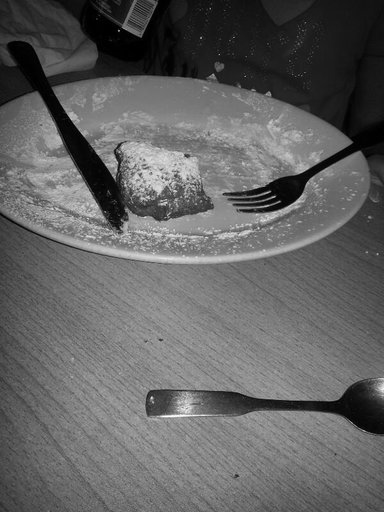

In [272]:
img.convert("L")

`#`

`-` `image_processor` 살펴보기 

In [274]:
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [279]:
image_processor.image_mean

[0.5, 0.5, 0.5]

In [281]:
image_processor.image_std

[0.5, 0.5, 0.5]

In [284]:
image_processor.size['height'],image_processor.size['width']

(224, 224)

`-` 코드는 아래와 같이 단순화하여 이해할 수 있음. 

In [306]:
_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop((224,224)), 
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food_transformed = food.with_transform(transforms)

`-` 주의점: `food.with_transform(transforms)`는 지연처리되는 코드임 

`food_transformed['train'][0:5]` 이것이 나오는 원리?

In [321]:
examples = food['train'][0:5]
transforms(examples)

{'label': [20, 6, 6, 81, 79],
 'pixel_values': [tensor([[[-0.4196, -0.4588, -0.4667,  ...,  0.9843,  0.9922,  0.9765],
           [-0.4353, -0.4745, -0.4588,  ...,  0.9922,  0.9922,  1.0000],
           [-0.4275, -0.4745, -0.4275,  ...,  0.9765,  0.9922,  1.0000],
           ...,
           [-0.3961, -0.4510, -0.5216,  ..., -0.6471, -0.7098, -0.7333],
           [-0.3725, -0.4275, -0.4980,  ..., -0.6863, -0.7412, -0.7647],
           [-0.3569, -0.4039, -0.4902,  ..., -0.7333, -0.7647, -0.7804]],
  
          [[-0.4510, -0.4980, -0.5059,  ...,  0.9922,  1.0000,  0.9922],
           [-0.4667, -0.5137, -0.4980,  ...,  0.9843,  0.9922,  1.0000],
           [-0.4588, -0.5137, -0.4667,  ...,  0.9765,  0.9922,  0.9922],
           ...,
           [-0.5216, -0.5686, -0.6314,  ..., -0.8588, -0.8588, -0.8588],
           [-0.5216, -0.5529, -0.6157,  ..., -0.8431, -0.8510, -0.8588],
           [-0.5294, -0.5608, -0.6157,  ..., -0.8510, -0.8588, -0.8510]],
  
          [[-0.6078, -0.6471, -0.6549,

## E. 모델생성 

`-` 아래의 코드를 관찰하자. 

In [440]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

`-` 아래와같이 해도 별로 상관없음

In [446]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [447]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`-` `model`을 이용하여 숫자계산하기 

In [466]:
model(이미지처리하기(img).reshape(1,3,224,224))

ImageClassifierOutput(loss=None, logits=tensor([[ 0.0150,  0.0218,  0.0188,  0.1206, -0.0085,  0.0643, -0.1483,  0.0163,
          0.0363,  0.0275,  0.0277, -0.0682,  0.0460,  0.0335, -0.0465, -0.0452,
         -0.0227,  0.0245,  0.0860, -0.0384, -0.1852,  0.0741, -0.0597, -0.1803,
          0.0413, -0.0195, -0.1533, -0.0174,  0.1193, -0.1062,  0.0721, -0.0009,
          0.0555, -0.0548,  0.0182, -0.1338,  0.1468, -0.1734, -0.0658, -0.0362,
          0.0313,  0.0357, -0.0278,  0.2275, -0.2479, -0.0601,  0.1431,  0.0543,
         -0.0421,  0.1420,  0.0549, -0.1055,  0.0004, -0.2870, -0.0185, -0.1590,
          0.0572, -0.1353,  0.0354, -0.0219, -0.1516,  0.0969, -0.0475, -0.1148,
         -0.0229,  0.0242, -0.1129,  0.0818, -0.1748,  0.0409,  0.0777,  0.1075,
         -0.0815, -0.0970,  0.0013,  0.0481, -0.0862,  0.0860,  0.1823, -0.0444,
          0.1407, -0.0637,  0.0325,  0.1610, -0.0647,  0.3267, -0.1497,  0.0136,
          0.1734,  0.0924, -0.0197,  0.0821, -0.1205, -0.0800, -0.217

In [467]:
model(표준화하기(자르고크기조정하기(텐서화하기(img))).reshape(1,3,224,224))

ImageClassifierOutput(loss=None, logits=tensor([[ 0.0141,  0.0215,  0.0185,  0.1205, -0.0082,  0.0649, -0.1479,  0.0158,
          0.0357,  0.0280,  0.0283, -0.0683,  0.0469,  0.0340, -0.0460, -0.0457,
         -0.0223,  0.0247,  0.0853, -0.0393, -0.1841,  0.0734, -0.0598, -0.1791,
          0.0415, -0.0185, -0.1534, -0.0172,  0.1190, -0.1056,  0.0723, -0.0006,
          0.0556, -0.0545,  0.0179, -0.1338,  0.1474, -0.1742, -0.0656, -0.0361,
          0.0309,  0.0358, -0.0287,  0.2275, -0.2478, -0.0603,  0.1433,  0.0545,
         -0.0422,  0.1422,  0.0544, -0.1059, -0.0004, -0.2870, -0.0188, -0.1595,
          0.0575, -0.1350,  0.0361, -0.0218, -0.1517,  0.0972, -0.0482, -0.1155,
         -0.0231,  0.0236, -0.1137,  0.0818, -0.1747,  0.0409,  0.0769,  0.1072,
         -0.0808, -0.0964,  0.0006,  0.0487, -0.0866,  0.0859,  0.1831, -0.0451,
          0.1412, -0.0634,  0.0333,  0.1617, -0.0648,  0.3276, -0.1505,  0.0140,
          0.1732,  0.0923, -0.0194,  0.0820, -0.1203, -0.0808, -0.216

## F. 데이터콜렉터 

`-` 데이터 콜렉터 생성 

In [496]:
data_collator = transformers.DefaultDataCollator()

`-` 데이터콜렉터에게 이번에 크게 기대하는건 없음.. 그냥 미니배치 정도만 묶어주면 됨

In [507]:
# food_transformed['train'][:2]['pixel_values']
# 이 자료는 [(3,224,224)-tensor, (3,224,224)-tensor] 와 같은 구조임
# 그런데 이 자료를 그대로 model에 넣는다면 돌아가지 않음. 
# 우리는 이 자료를 (2,3,224,224)-tensor 로 바꾸어 모델에 입력해주어야함

In [509]:
import torch
model(torch.stack(food_transformed['train'][:2]['pixel_values'],axis=0))

In [523]:
torch.stack(food_transformed['train'][:2]['pixel_values'],axis=0) # 이코드 어렵죠

tensor([[[[-0.5608, -0.5843, -0.6000,  ..., -0.8196, -0.8196, -0.8196],
          [-0.5765, -0.5922, -0.6078,  ..., -0.8196, -0.8196, -0.8118],
          [-0.5922, -0.6078, -0.6235,  ..., -0.8275, -0.8275, -0.8196],
          ...,
          [-0.4118, -0.4745, -0.5294,  ...,  0.0431,  0.0431,  0.0588],
          [-0.4039, -0.4667, -0.5216,  ...,  0.0353,  0.0196,  0.0275],
          [-0.4039, -0.4667, -0.5137,  ...,  0.0353,  0.0118,  0.0039]],

         [[-0.8275, -0.8510, -0.8667,  ..., -0.8353, -0.8353, -0.8353],
          [-0.8118, -0.8275, -0.8353,  ..., -0.8431, -0.8431, -0.8431],
          [-0.8118, -0.8196, -0.8275,  ..., -0.8588, -0.8588, -0.8510],
          ...,
          [-0.6392, -0.6706, -0.7098,  ..., -0.4275, -0.4431, -0.4431],
          [-0.6392, -0.6706, -0.7020,  ..., -0.4196, -0.4510, -0.4667],
          [-0.6392, -0.6706, -0.7020,  ..., -0.4118, -0.4588, -0.4745]],

         [[-0.9216, -0.9451, -0.9608,  ..., -0.9373, -0.9451, -0.9529],
          [-0.9529, -0.9608, -

In [524]:
data_collator([food['train'][0],food['train'][1]])['pixel_values'].shape # 이렇게 씀

torch.Size([2, 3, 224, 224])

## G. 추론 

`-` 코드정리1에 의하여 이미 학습되어있는 Trainer 

In [525]:
# Step4 
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-186")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


`-` image url 에서 PIL 오브젝트 만들기: GPT 답변 

```Python
from PIL import Image
import requests
from io import BytesIO

# 이미지 URL
url = "https://example.com/image.jpg"

# URL에서 이미지 불러오기
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# 이미지 확인
image.show()
```

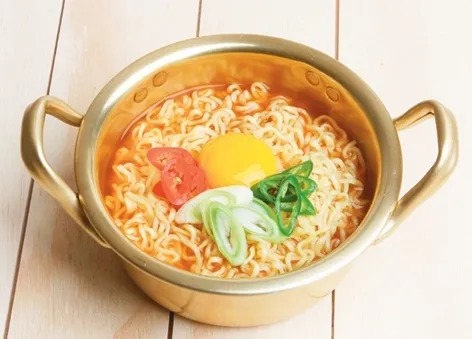

In [538]:
from PIL import Image
import requests
from io import BytesIO

# 이미지 URL
url = "https://i.namu.wiki/i/eYVvNJnEv7iWMzCOChZ0BeQm1HVG2sqOWiEABGD3Q5yUilrg8rtVrTc0MupDB9DtGBzioQ5JLfPSPR_AuajlNWsOJsm6gp-EnrcKzcHjHGvzoldry6NiVpZHrNTF2WM9bY4Y546kCtsE1n1yTv4TUg.webp"

# URL에서 이미지 불러오기
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image

In [540]:
classifier(image)

[{'label': 'ramen', 'score': 0.9660526514053345},
 {'label': 'hamburger', 'score': 0.648557722568512},
 {'label': 'beignets', 'score': 0.6234114170074463},
 {'label': 'prime_rib', 'score': 0.5963582992553711},
 {'label': 'bruschetta', 'score': 0.5791028141975403}]

# 6. 코드정리2

In [541]:
## Step1 
food = datasets.load_dataset("food101", split="train[:5000]").train_test_split(test_size=0.2)
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
def transforms(examples):
    _transforms = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224), 
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    examples["pixel_values"] = [_transforms(img) for img in examples["image"]]
    del examples["image"]
    return examples
food = food.with_transform(transforms)
## Step2 
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)
## Step3 
data_collator = transformers.DefaultDataCollator()
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)
training_args = transformers.TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)
trainer.train()
## Step4 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
0,2.705600,2.571837,0.813000
2,1.363800,1.371698,0.901000
3,1.207400,1.301172,0.891000


TrainOutput(global_step=248, training_loss=2.094045119900857, metrics={'train_runtime': 186.2547, 'train_samples_per_second': 85.904, 'train_steps_per_second': 1.332, 'total_flos': 1.2310442033283072e+18, 'train_loss': 2.094045119900857, 'epoch': 3.968})

In [542]:
# Step4 
ds = datasets.load_dataset("food101", split="validation[:10]")
image = ds["image"][0]
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-248")
classifier(image)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'beignets', 'score': 0.9772622585296631},
 {'label': 'bruschetta', 'score': 0.7185885906219482},
 {'label': 'chicken_wings', 'score': 0.6148561835289001},
 {'label': 'pork_chop', 'score': 0.6061304211616516},
 {'label': 'prime_rib', 'score': 0.5966430306434631}]